100%|██████████| 1327/1327 [00:00<00:00, 1350.78it/s]


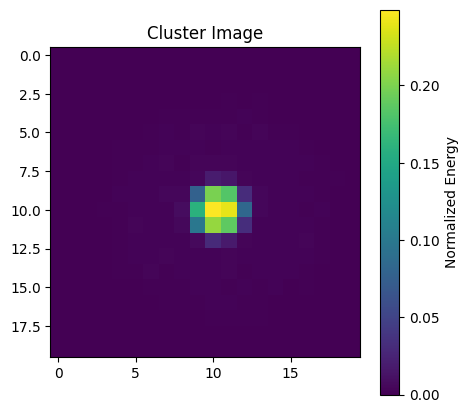

In [10]:
import pandas as pd
import numpy as np
import ast
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt  # Для визуализации

def parse_cluster_pixels(cluster_pixels_str):
    """
    Разбирает строку формата '[x, y, E, t][x, y, E, t]...' в список координат и значений энергии.
    """
    cluster_pixels = ast.literal_eval(cluster_pixels_str.replace('][', '],['))
    return [(int(x), int(y), float(E)) for x, y, E, t in cluster_pixels]

def normalize_energy(data, E_min, E_max):
    """
    Нормализует значение энергии по диапазону [E_min, E_max].
    """
    return [(x, y, (E - E_min) / (E_max - E_min)) for x, y, E in data]

def center_and_scale_coordinates(cluster_data, image_size):
    """
    Центрирует координаты кластера в пределах изображения и масштабирует их.
    """
    x_coords = np.array([x for x, _, _ in cluster_data])
    y_coords = np.array([y for _, y, _ in cluster_data])
    
    # Определяем смещения для центрирования
    x_center_shift = (image_size[0] // 2) - int(np.round(x_coords.mean()))
    y_center_shift = (image_size[1] // 2) - int(np.round(y_coords.mean()))
    
    # Применяем смещения к координатам
    x_centered = x_coords + x_center_shift
    y_centered = y_coords + y_center_shift
    
    # Ограничиваем координаты рамками изображения
    x_centered = np.clip(x_centered, 0, image_size[0] - 1)
    y_centered = np.clip(y_centered, 0, image_size[1] - 1)

    # Собираем новые координаты с учетом энергии
    centered_cluster_data = [(x, y, E) for (x, y, E), x, y in zip(cluster_data, x_centered, y_centered)]
    
    return centered_cluster_data



def create_image(cluster_data, image_size=(256, 256)):
    """
    Создает двумерное изображение на основе координат и значений энергии.
    """
    image = np.zeros(image_size)
    for x, y, E in cluster_data:
        if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
            image[x, y] = E
    return image

def process_file(input_file, output_dir, E_min, E_max, image_size=(256, 256), max_rows=None):
    """
    Обрабатывает файл с кластерами и сохраняет изображения.
    """
    # Создаем директорию для сохранения изображений
    os.makedirs(output_dir, exist_ok=True)

    # Читаем файл
    df = pd.read_csv(input_file, sep='\t')

    # Если задано ограничение на количество строк
    if max_rows is not None:
        df = df.head(max_rows)

    # Извлекаем и обрабатываем `ClusterPixels`
    for index, row in tqdm(df.iterrows(), total=len(df)):
        cluster_pixels_str = row['ClusterPixels']
        cluster_data = parse_cluster_pixels(cluster_pixels_str)

        # Нормализация энергии
        cluster_data = normalize_energy(cluster_data, E_min, E_max)

        # Центрирование и масштабирование
        cluster_data = center_and_scale_coordinates(cluster_data, image_size)

        # Создаем изображение
        image = create_image(cluster_data, image_size=image_size)

        # Сохраняем изображение
        output_path = Path(output_dir) / f"image_{index}.npy"
        np.save(output_path, image)

def compute_global_energy_range(files):
    """
    Вычисляет общий диапазон энергий для нескольких файлов.
    """
    all_energies = []
    for file in files:
        df = pd.read_csv(file, sep='\t')
        for _, row in df.iterrows():
            cluster_pixels_str = row['ClusterPixels']
            cluster_data = parse_cluster_pixels(cluster_pixels_str)
            all_energies.extend([E for _, _, E in cluster_data])
    return min(all_energies), max(all_energies)

def visualize_image(image_path):
    """
    Визуализирует изображение, сохраненное в формате .npy.
    """
    image = np.load(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='viridis')
    plt.colorbar(label='Normalized Energy')
    plt.title("Cluster Image")
    plt.show()

# Параметры
experiment_file = "Am_TPX3_vacuum_prelim_E_5p49MeV.clist"
simulation_file = "80V_TPX3_alpha_particle_simulation_in_vacuum.clist"
output_dir_experiment = "processed_experiment_images"
output_dir_simulation = "processed_simulation_images"
image_size = (20, 20)  # Задайте нужный размер изображения
max_rows_experiment = 1327  # Ограничение для experiment_file

# Вычисление общего диапазона энергии
E_min, E_max = compute_global_energy_range([experiment_file, simulation_file])

# Обработка данных
process_file(experiment_file, output_dir_experiment, E_min, E_max, image_size, max_rows=max_rows_experiment)
process_file(simulation_file, output_dir_simulation, E_min, E_max, image_size)

# Визуализация примера
example_image_path = Path(output_dir_experiment) / "image_0.npy"
visualize_image(example_image_path)


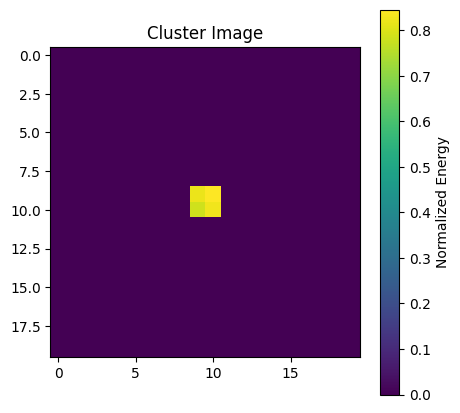

In [13]:
# Визуализация примера
example_image_path = Path(output_dir_simulation) / "image_1200.npy"
visualize_image(example_image_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Утилита для загрузки данных
def load_images(data_dir, image_size=(20, 20)):
    images = []
    for file_name in tqdm(os.listdir(data_dir)):
        if file_name.endswith(".npy"):
            image = np.load(os.path.join(data_dir, file_name))
            image = tf.image.resize(image, image_size)  # Изменение размера, если нужно
            images.append(image)
    images = np.array(images)
    images = (images - 0.5) * 2  # Нормализация в диапазон [-1, 1]
    return images

# Загрузка данных
simulation_dir = "/path_to_simulation_data"
experiment_dir = "/path_to_experiment_data"

sim_images = load_images(simulation_dir)
exp_images = load_images(experiment_dir)

# Функция для построения генератора
def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    outputs = Conv2D(1, kernel_size=7, padding="same", activation="tanh")(x)
    return Model(inputs, outputs, name="generator")

# Функция для построения дискриминатора
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(1, kernel_size=4, padding="same")(x)
    outputs = tf.keras.activations.sigmoid(x)
    return Model(inputs, outputs, name="discriminator")

# Построение моделей
input_shape = (20, 20, 1)
gen_G = build_generator(input_shape)
gen_F = build_generator(input_shape)
disc_X = build_discriminator(input_shape)
disc_Y = build_discriminator(input_shape)

# Заморозка дискриминаторов для обучения генераторов
disc_X.trainable = False
disc_Y.trainable = False

# Loss функции и оптимизаторы
loss_fn = tf.keras.losses.MeanSquaredError()
cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Компиляция моделей
gen_G.compile(optimizer=optimizer, loss=loss_fn)
gen_F.compile(optimizer=optimizer, loss=loss_fn)
disc_X.compile(optimizer=optimizer, loss=loss_fn)
disc_Y.compile(optimizer=optimizer, loss=loss_fn)

# Обучение
batch_size = 16
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i in range(0, len(sim_images), batch_size):
        sim_batch = sim_images[i:i+batch_size]
        exp_batch = exp_images[i:i+batch_size]

        # Генерация и обучение
        fake_exp = gen_G.predict(sim_batch)
        fake_sim = gen_F.predict(exp_batch)

        # Обновление дискриминаторов
        disc_X.train_on_batch(sim_batch, fake_sim)
        disc_Y.train_on_batch(exp_batch, fake_exp)

        # Обновление генераторов (Cycle Consistency Loss)
        cycle_sim = gen_F.predict(fake_exp)
        cycle_exp = gen_G.predict(fake_sim)
        gen_G.train_on_batch(sim_batch, cycle_loss_fn(exp_batch, cycle_exp))
        gen_F.train_on_batch(exp_batch, cycle_loss_fn(sim_batch, cycle_sim))

    # Визуализация прогресса
    if epoch % 10 == 0:
        example_sim = sim_images[0:1]
        example_generated = gen_G.predict(example_sim)[0]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Simulation Input")
        plt.imshow(example_sim[0].squeeze(), cmap="viridis")
        plt.subplot(1, 2, 2)
        plt.title("Generated Experiment")
        plt.imshow(example_generated.squeeze(), cmap="viridis")
        plt.show()
